# Lab session taught by Oladimeji Mudele

Welcome to this lab session on Time series modeling for air pollution monitoring with a focus on the
calibration of low-cost sensors.

This lab session is based on the data and methods provided in the study by [Ellen M. Considine et al](https://www.sciencedirect.com/science/article/pii/S0269749120365222).

Rather than focus on code efficiency, software engineering practices, or theory of machine learning models, this course focuses on the **thought processes** (as generalised as possible) that apply to tackling many data science problems. Don't worry if you don't understanding certain nuances around syntax or code implementations. These problems are always easier to tackle. My advice is that you focus on the "WHY?".

The interesting part of this course module is that, rather than work with cleaned data and do our explorations and modeling from there, we will try to simulate the real-life scenario of merging data from multple sources (sensors) and time periods, and also engineer the features we need for our prediction task.

In certain events in data science, you might be lucky to have your data stuctured and prepared for you. Most often, this is not the case.

Welcome to the world of data science.

In this notebook, we will prepare the training and test data. In ths process we will go through the following steps:

- **Understading the problem**: This leads us to the question: "**What data do I need?**"
- **Diving into the data**: This is simply looking at your data (each column), and asking yourself, what does it mean? Why do I need it? How would I use it for my task? What units are the data expressed in?
- Aligning the different axis and features in the multi-source/multitemporal data
- **Cleaning**: dealing with invalid and missing values. For example, in the case of our project, the low-cost Canary-S (CS) sensor readings register -1 as invalid values and the authors of our reference literature mentioned 1500 units of PM2.5 as the maximum threhold. We need to handle these cases. Also, we need to check for rows with missing values.
- **Merging**: pull data from multiple sources into a single frame.
- **Features crafting**: Based on our understanding of the problem we are trying to solve, it might be useful to take some of the information in th dsta and use them to craft features we believe will udeful for our model to learn what it needs to learn in other to produce the best results.

# WHAT IS OUR PROBLEM?

We have PM2.5 readings from low cost sensors and we want to learn a model that maps them to "true" readings from reference FEM (AirNow) sensors . 

# WHAT DATA DO WE NEED?

##### The obvious and basic ones:
- PM2.5 readings from AirNow sensors
- PM2.5 readings from CS sensors

##### What other data or features might we need? (Our experiments will determine what is eventually useful
- lenght of road with certain radius from sensing location.
- Time variables
- temperature  
- humidity
- day of the week (weekend or not)

# NOW LET US DIVE INTO CODE

First, I like to use `black`formatter. Makes my code more readable. Install it using `!pip install nb_black` in a cell below

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

We need some Python libraries to enable efficient implementations of computations. The libraries we need are `numpy`, `pandas`and the `math`module which is part of the python standard library. For now, please ensure to install both `numpy`and `pandas`.

Now, let us import these libraries into our workspace.

In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

Now, we are done with preparing ourselves for the data preparation phase. Here we go!

# TRAINING DATA

### Load the data from disk and explain the details

Let us specify the subfolder in our project folder where you have kept all the data. 

In [3]:
data_root = "./data/"  # change this to your own subfolder. Ideally, it should be the same as defined here.

<IPython.core.display.Javascript object>

In the `data` subfolder, you will find a couple of csv files, the raw training data is in a file named `raw_collocated_data.csv`. Let us load that file.

In [4]:
training_data_path = (
    data_root + "raw_collocated_data.csv"
)  # first we define the file location using string concatenation

<IPython.core.display.Javascript object>

In [5]:
raw_training_data = pd.read_csv(
    training_data_path
)  # Here we load the data as a dataframe

<IPython.core.display.Javascript object>

### So, what are the columns in our data and what do they mean?

In [6]:
raw_training_data.columns

Index(['DateTime', 'PM2_5(NJH CS Collo (CS1)/Canary-S)',
       'tempf(NJH CS Collo (CS1)/Canary-S)',
       'humidity(NJH CS Collo (CS1)/Canary-S)', 'PM2.5(NJH/AirNow)',
       'PM2_5(I-25 Glo Collo (CS2)/Canary-S)',
       'tempf(I-25 Glo Collo (CS2)/Canary-S)',
       'humidity(I-25 Glo Collo (CS2)/Canary-S)',
       'PM2_5(I-25 Glo Collo (CS3)/Canary-S)',
       'tempf(I-25 Glo Collo (CS3)/Canary-S)',
       'humidity(I-25 Glo Collo (CS3)/Canary-S)',
       'PM2_5(I-25 Glo Collo (CS4)/Canary-S)',
       'tempf(I-25 Glo Collo (CS4)/Canary-S)',
       'humidity(I-25 Glo Collo (CS4)/Canary-S)',
       'PM2.5(I-25 Globeville/AirNow)', 'PM2_5(La Casa Collo (CS5)/Canary-S)',
       'tempf(La Casa Collo (CS5)/Canary-S)',
       'humidity(La Casa Collo (CS5)/Canary-S)', 'PM2.5(La Casa/AirNow)',
       'PM2_5(Swansea Elementary Collo (CS7)/Canary-S)',
       'tempf(Swansea Elementary Collo (CS7)/Canary-S)',
       'humidity(Swansea Elementary Collo (CS7)/Canary-S)',
       'PM2.5(I-25 Denve

<IPython.core.display.Javascript object>

It is important to ensure that you understandevery variable in the columns of your dataframe. In essense: 

Why do we need each of these variables (if at all)?

In what way do we have to organise the data to make them most useful to us?

### Understanding the data content in our dataframe

In summary, we need to look at each column and ask ourselves what information it contains, why and how we will need the information

CS#: Canary sensor number # <br>
AirNow: FEM reference data source


`DateTime`: Date and time that data was registered by sensor
<hr style="border:2px solid gray">

`PM2_5(NJH CS Collo (CS1)/Canary-S)` : PM2.5 readings from CS1 located at NJH <br>
`tempf(NJH CS Collo (CS1)/Canary-S)` : Temperature (Farenheit) readings from CS2 located at NJH <br>
`humidity(NJH CS Collo (CS1)/Canary-S)` : Humidity readings from CS1 located at NJH <br>
`PM2.5 (NJH/AirNow)`: PM2.5 readings from the reference FEM sensor located at NJH
<hr style="border:2px solid gray">

`PM2_5(I-25 Glo Collo (CS2)/Canary-S)` : PM2.5 readings from CS2 sensor located at I-25 Globeville <br>
`tempf(I-25 Glo Collo (CS2)/Canary-S)` : Temperature (Farenheit) readings from CS2 located at I-25 Globeville <br>
`humidity(I-25 Glo Collo (CS2)/Canary-S)` : Humidity readings from CS2 located at I-25 Globeville <br>
<hr style="border:2px solid gray">

`PM2_5(I-25 Glo Collo (CS3)/Canary-S)` : PM2.5 readings from CS3 sensor located at I-25 Globeville <br>
`tempf(I-25 Glo Collo (CS3)/Canary-S)` : Temperature (Farenheit) readings from CS3 located at I-25 Globeville <br>
`humidity(I-25 Glo Collo (CS3)/Canary-S)` : Humidity readings from CS3 located at I-25 Globeville <br>
<hr style="border:2px solid gray">

`PM2_5(I-25 Glo Collo (CS4)/Canary-S)` : PM2.5 readings from CS4 sensor located at I-25 Globeville <br>
`tempf(I-25 Glo Collo (CS4)/Canary-S)` : Temperature (Farenheit) readings from CS4 located at I-25 Globeville <br>
`humidity(I-25 Glo Collo (CS4)/Canary-S)` : Humidity readings from CS4 located at I-25 Globeville <br>
`PM2.5(I-25 Globeville/AirNow)`: PM2.5 readings from the reference FEM sensor located at I-25 Globeville
<hr style="border:2px solid gray">

`PM2_5(La Casa Collo (CS5)/Canary-S)` : PM2.5 readings from CS5 sensor located at La Casa <br>
`tempf(La Casa Collo (CS5)/Canary-S)` : Temperature (Farenheit) readings from CS5 located at La Casa <br>
`humidity(La Casa Collo (CS5)/Canary-S)` : Humidity readings from CS5 located at La Casa <br>
`'PM2.5(La Casa/AirNow)`: PM2.5 readings from the reference FEM sensor located at La Casa
<hr style="border:2px solid gray">

`PM2_5(Swansea Elementary Collo (CS7)/Canary-S)` : PM2.5 readings from CS5 sensor located at Swansea Elementary<br>
`tempf(Swansea Elementary Collo (CS7)/Canary-S)` : Temperature (Farenheit) readings from CS5 located at Swansea Elementary <br>
`humidity(Swansea Elementary Collo (CS7)/Canary-S)` : Humidity readings from CS5 located at Swansea Elementary<br>
`PM2.5(I-25 Denver/AirNow)`: PM2.5 readings from the reference FEM sensor located at I-25 Denver
<hr style="border:2px solid gray">

### Units of our observations

Temperature: Fahrenheit <br>
Humidity: grams of water vapor per kilogram of air <br>
PM2.5:  $µg/m^3$ <br>

### Checking for data types

Similar vairables should be of the same type. E.g PM2.5 measures by all sensors, ideally, should come in the same datatypes. If not, we will have to cast them to a common datatype

In [7]:
raw_training_data.dtypes

DateTime                                              object
PM2_5(NJH CS Collo (CS1)/Canary-S)                   float64
tempf(NJH CS Collo (CS1)/Canary-S)                   float64
humidity(NJH CS Collo (CS1)/Canary-S)                float64
PM2.5(NJH/AirNow)                                    float64
PM2_5(I-25 Glo Collo (CS2)/Canary-S)                 float64
tempf(I-25 Glo Collo (CS2)/Canary-S)                 float64
humidity(I-25 Glo Collo (CS2)/Canary-S)              float64
PM2_5(I-25 Glo Collo (CS3)/Canary-S)                 float64
tempf(I-25 Glo Collo (CS3)/Canary-S)                 float64
humidity(I-25 Glo Collo (CS3)/Canary-S)              float64
PM2_5(I-25 Glo Collo (CS4)/Canary-S)                 float64
tempf(I-25 Glo Collo (CS4)/Canary-S)                 float64
humidity(I-25 Glo Collo (CS4)/Canary-S)              float64
PM2.5(I-25 Globeville/AirNow)                        float64
PM2_5(La Casa Collo (CS5)/Canary-S)                  float64
tempf(La Casa Collo (CS5

<IPython.core.display.Javascript object>

Since we have a Date/Time variable/column in our dataframe, it is important to ensure we let pandas know (explicitly) that this particular column column should be treated as a datetime column type.

Let us cast the datetime column in our dataframe into a datetime type.

In [8]:
raw_training_data["DateTime"] = pd.to_datetime(raw_training_data["DateTime"])

<IPython.core.display.Javascript object>

As shown below, our `DateTime`column is now of the `datetime64`type.

In [9]:
raw_training_data.dtypes

DateTime                                             datetime64[ns]
PM2_5(NJH CS Collo (CS1)/Canary-S)                          float64
tempf(NJH CS Collo (CS1)/Canary-S)                          float64
humidity(NJH CS Collo (CS1)/Canary-S)                       float64
PM2.5(NJH/AirNow)                                           float64
PM2_5(I-25 Glo Collo (CS2)/Canary-S)                        float64
tempf(I-25 Glo Collo (CS2)/Canary-S)                        float64
humidity(I-25 Glo Collo (CS2)/Canary-S)                     float64
PM2_5(I-25 Glo Collo (CS3)/Canary-S)                        float64
tempf(I-25 Glo Collo (CS3)/Canary-S)                        float64
humidity(I-25 Glo Collo (CS3)/Canary-S)                     float64
PM2_5(I-25 Glo Collo (CS4)/Canary-S)                        float64
tempf(I-25 Glo Collo (CS4)/Canary-S)                        float64
humidity(I-25 Glo Collo (CS4)/Canary-S)                     float64
PM2.5(I-25 Globeville/AirNow)                   

<IPython.core.display.Javascript object>

### Is this how our data should be organised/arranged?


The cell below helps us to acheive this need rearrangement of our data. In the cell, we create a vriable called `full_training_data` where we store our rearranged training data.

In [10]:
i15_reference_reading = "PM2.5(I-25 Globeville/AirNow)"

full_training_data = pd.DataFrame(
    np.vstack(
        [
            raw_training_data.iloc[:, 1:5],
            pd.concat(
                [
                    raw_training_data.iloc[:, 5:8],
                    raw_training_data[i15_reference_reading],
                ],
                axis=1,
            ),
            pd.concat(
                [
                    raw_training_data.iloc[:, 8:11],
                    raw_training_data[i15_reference_reading],
                ],
                axis=1,
            ),
            raw_training_data.iloc[:, 11:15],
            raw_training_data.iloc[:, 15:19],
        ]
    ),
    columns=["pm_cs", "temp", "humidity", "pm_airnow"],
)

<IPython.core.display.Javascript object>

In [11]:
full_training_data["date_time"] = pd.to_datetime(
    pd.concat([raw_training_data.iloc[:, 0]] * 5, ignore_index=True)
)

<IPython.core.display.Javascript object>

Let is check the columns in our data

In [12]:
full_training_data.columns

Index(['pm_cs', 'temp', 'humidity', 'pm_airnow', 'date_time'], dtype='object')

<IPython.core.display.Javascript object>

We now have a dataframe with columns defined as `["pm_cs", "temp", "humidity", "pm_airnow", "data_time"]`.

`pm_cs`: PM2.5 measured from tne CS sensors (low cost) <br>
`pm_airnow`: PM2.5 measured from the AirNow sensors <br>
`date_time`: Date and time information <br>
`temp`: temperature readings <br>
`humidity`: humidity readings from the CS sensors <br>

Now, let us check the number of rows in our data.

In [13]:
print(f"There are {len(full_training_data)} rows in our data")

There are 34085 rows in our data


<IPython.core.display.Javascript object>

In [14]:
full_training_data.head()

,pm_cs,temp,humidity,pm_airnow,date_time
0,33.6167,60.038,65.0850,22.10,2018-08-20 01:00:00
1,38.2333,58.517,67.1150,27.10,2018-08-20 02:00:00
2,43.3500,57.383,71.1717,28.85,2018-08-20 03:00:00
3,48.7000,56.546,74.7317,34.60,2018-08-20 04:00:00
4,39.2500,55.682,79.2033,31.50,2018-08-20 05:00:00


<IPython.core.display.Javascript object>

Time to start adding new features that might be useful

### Adding sensor location label to our data (useful as tag)

This helps to keep track of the different sensing locations durihg our data exploration and modeling. 

Because we have the same reference monitor for the three collocated sensors at i-25 Globeville, we will have to keep track of the `airnow_sensor` and `cs_sensor` differently. Below we create these 2 columns.

In [15]:
cs_sensor = ["NJH", "i25_glo_1", "i25_glo_2", "i25_glo_3", "la_casa"]
cs_sensor_col = np.repeat(
    cs_sensor, len(raw_training_data)
)  # note that we repeat in accordance to the raw data size.

full_training_data["cs_sensor"] = cs_sensor_col

<IPython.core.display.Javascript object>

In [16]:
full_training_data["airnow_sensor"] = full_training_data["cs_sensor"].apply(
    lambda x: "i25_glo" if x in ["i25_glo_1", "i25_glo_2", "i25_glo_3"] else x
)

<IPython.core.display.Javascript object>

So far, we have now defined the following columns in our data: `["pm_cs", "temp", "humidity", "pm_airnow", "data_time", "cs_sensor", "airnow_sensor"]`

### Accounting for seasonal and time effects through hour,  month, and weekend variables 

Because of daily, weekly, and seasonal variation in atmospheric PM2.5 that may be due to factors beyond temperature and relative humidity, we will extract hour, weekend, and month variables and convert the `hour` and `month`variables into cyclic values by taking the `cosine` and `sine` of $hour*2π/24$  and $month*2π/12$.

###### Why do we need sine and cosine encoding of time related features?

Some data are inherently cyclical. Time is an enaple of such: minutes, hours, seconds, day of week, week of month, month, season, and so on all follow cycles. 

**How can we let our machine learning model know that a feature is cyclical?** <br>
By using sine and cosine transformations

In the cell below, I have created a dummy data for each hour in day and have showed how we can tranform the data from linear (1-demensional) to cyclical (2-dimensional using cosine and sine transformations

This [reference](https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/) gives a good explanation. 



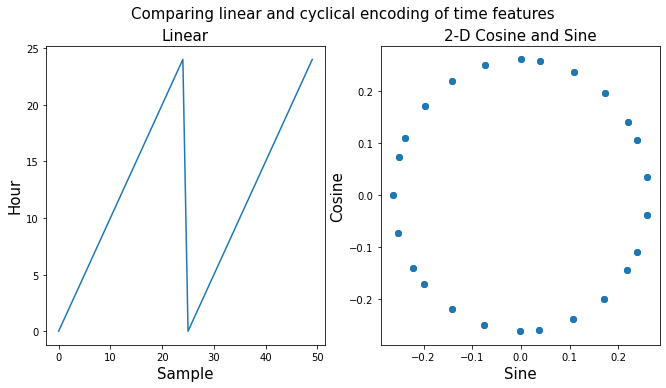

<IPython.core.display.Javascript object>

In [17]:
# Example that explains cyclical encoding

time = [x for x in range(0, 24 + 1)]  # create a dummy list every hour in the data

time = time + time  # Concatenate copies of the same list to form 2 days

cos_time = [(math.cos(x) * 2 * (math.pi / 24)) for x in time]
sin_time = [(math.sin(x) * 2 * (math.pi / 24)) for x in time]

fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(11, 5.5))

ax1.plot(time)
ax2.scatter(sin_time, cos_time)
ax1.set_title("Linear", size=15)
ax2.set_title("2-D Cosine and Sine", size=15)
ax1.set_ylabel("Hour", size=15)
ax1.set_xlabel("Sample", size=15)
ax2.set_ylabel("Cosine", size=15)
ax2.set_xlabel("Sine", size=15)
plt.suptitle("Comparing linear and cyclical encoding of time features", size=15)
plt.show()

Notice the boundary between 24 and 0. In time, we know that 24 and 0 should be the same. Cyclical encoding helps us achieve this behaviour.

This approach is one of the ways to handle time information in time series data.

In [18]:
full_training_data["time"] = full_training_data["date_time"].dt.hour
full_training_data["month"] = full_training_data["date_time"].dt.month


full_training_data["weekend"] = (
    full_training_data["date_time"].dt.dayofweek >= 4
).astype("int")

<IPython.core.display.Javascript object>

In [19]:
full_training_data["sin_time"] = full_training_data["time"].apply(
    lambda x: math.sin(x) * 2 * (math.pi / 24)
)
full_training_data["cos_time"] = full_training_data["time"].apply(
    lambda x: math.cos(x) * 2 * (math.pi / 24)
)

full_training_data["sin_month"] = full_training_data["month"].apply(
    lambda x: math.sin(x) * 2 * (math.pi / 12)
)

full_training_data["cos_month"] = full_training_data["month"].apply(
    lambda x: math.cos(x) * 2 * (math.pi / 12)
)

<IPython.core.display.Javascript object>

### Dealing with missing values (NaN) and invalid values.

We need to rely on the literature or the data provider to undertstand how to filter the data and wghat to filter out and/or keep in the data.

In [20]:
print(f"We are starting with {len(full_training_data)} observations")

We are starting with 34085 observations


<IPython.core.display.Javascript object>

#### Setting the threshold for invalid values

In [21]:
low = 0  # CS encodes invalid values as -1
high = 1500

<IPython.core.display.Javascript object>

In [22]:
full_training_data = full_training_data[
    (full_training_data["pm_airnow"] > low)
    & (full_training_data["pm_cs"] > low)
    & (full_training_data["temp"] > low)
    & (full_training_data["humidity"] > low)
    & (full_training_data["pm_cs"] < high)
]


<IPython.core.display.Javascript object>

In [23]:
# Drop NaN values

full_training_data = full_training_data.dropna(
    subset=["pm_cs", "temp", "humidity", "pm_airnow"]
)

<IPython.core.display.Javascript object>

In [24]:
print(
    f"Now we are left with {len(full_training_data)} hourly observation as our training data"
)

Now we are left with 29729 hourly observation as our training data


<IPython.core.display.Javascript object>

### Add road length variables

Along with adjusting for variability in time, it is useful to investigate variability in space (location of reference sensors). The position of an air quality sensor within a city, especially relative to known sources of pollution such as highways, is likely to affect the characteristics of the air pollution in that area.

In this regard, the authors of our reference study investigated the effects of lengths of different sizes of roads within a certain distance from a monitor. 

For this particular course, we will including the lenght of arterial (large) roads within 500m (to be tagged `aroad_500`).

ALERT: The lengths here could have been measured in kilometers or Miles. What is most important is that they are all measured on the same unit, which we can believe is the case.

The data  we load below provides us with data on lenght of arterial (large) roads within 500m of each monitor locations.

In [25]:
road_data = pd.read_csv(data_root + "road_lengths.csv")

<IPython.core.display.Javascript object>

In [26]:
road_data.head()

,airnow_sensor,longitude,latitude,a_road_500
0,NJH,-104.939925,39.738578,1.995
1,i25_glo,-104.988878,39.785902,1.295
2,la_casa,-105.005191,39.779467,1.727
3,CAMP,-104.987625,39.751184,6.850
4,i25_denver,-105.015317,39.732146,2.195


<IPython.core.display.Javascript object>

In [27]:
print("Before merging road lenghts variables")
full_training_data.head()

Before merging road lenghts variables


,pm_cs,temp,humidity,pm_airnow,date_time,cs_sensor,airnow_sensor,time,month,weekend,sin_time,cos_time,sin_month,cos_month
0,33.6167,60.038,65.0850,22.10,2018-08-20 01:00:00,NJH,NJH,1,8,0,0.220297,0.141451,0.518027,-0.076184
1,38.2333,58.517,67.1150,27.10,2018-08-20 02:00:00,NJH,NJH,2,8,0,0.238054,-0.108947,0.518027,-0.076184
2,43.3500,57.383,71.1717,28.85,2018-08-20 03:00:00,NJH,NJH,3,8,0,0.036945,-0.259179,0.518027,-0.076184
3,48.7000,56.546,74.7317,34.60,2018-08-20 04:00:00,NJH,NJH,4,8,0,-0.198130,-0.171123,0.518027,-0.076184
4,39.2500,55.682,79.2033,31.50,2018-08-20 05:00:00,NJH,NJH,5,8,0,-0.251046,0.074263,0.518027,-0.076184


<IPython.core.display.Javascript object>

In [28]:
full_training_data = road_data.merge(full_training_data, on="airnow_sensor")

<IPython.core.display.Javascript object>

In [29]:
print(
    "After merging road lenghts variables. Longitude and latitude information are also added"
)
full_training_data.head()

After merging road lenghts variables. Longitude and latitude information are also added


,airnow_sensor,longitude,latitude,a_road_500,pm_cs,temp,humidity,pm_airnow,date_time,cs_sensor,time,month,weekend,sin_time,cos_time,sin_month,cos_month
0,NJH,-104.939925,39.738578,1.995,33.6167,60.038,65.0850,22.10,2018-08-20 01:00:00,NJH,1,8,0,0.220297,0.141451,0.518027,-0.076184
1,NJH,-104.939925,39.738578,1.995,38.2333,58.517,67.1150,27.10,2018-08-20 02:00:00,NJH,2,8,0,0.238054,-0.108947,0.518027,-0.076184
2,NJH,-104.939925,39.738578,1.995,43.3500,57.383,71.1717,28.85,2018-08-20 03:00:00,NJH,3,8,0,0.036945,-0.259179,0.518027,-0.076184
3,NJH,-104.939925,39.738578,1.995,48.7000,56.546,74.7317,34.60,2018-08-20 04:00:00,NJH,4,8,0,-0.198130,-0.171123,0.518027,-0.076184
4,NJH,-104.939925,39.738578,1.995,39.2500,55.682,79.2033,31.50,2018-08-20 05:00:00,NJH,5,8,0,-0.251046,0.074263,0.518027,-0.076184


<IPython.core.display.Javascript object>

Now, let look below to ensure that all the columns we need in our data have been added. 

In [30]:
full_training_data.columns

Index(['airnow_sensor', 'longitude', 'latitude', 'a_road_500', 'pm_cs', 'temp',
       'humidity', 'pm_airnow', 'date_time', 'cs_sensor', 'time', 'month',
       'weekend', 'sin_time', 'cos_time', 'sin_month', 'cos_month'],
      dtype='object')

<IPython.core.display.Javascript object>

### Note about training data preparation

This is our training data preparation. Take note that most real life data science objectives require **rigourous data preparation and feature engineeering**. This lesson has shown you a bit of what that looks like. Now we want to save our cleaned data in a `.csv`file.

### Finally, save the new version of your training data as a `.csv` file

We will use this file in the remaining notebooks (for exploratory data analysis and modeling)

In [31]:
full_training_data.to_csv(data_root + "cleaned_training.csv", index=False)

<IPython.core.display.Javascript object>

### Now, let us recall have has been done so far.

We have taken our training data from its raw state to a cleaned state. Now, it is ready to be used for further tasks. 

What exactly did we do so far:

1. Checked the columns in the data and interpret them.
2. Checked the datatypes and cast to the right datatype where necessary.
3. Reorganised our data. We collected data for each CS sensor and from the columns that contain them and stacked all these data on top of one another.
4. Dealt with missing or invalid data. In our own case we dropped them, in other cases you can input them using heuristics or interpolation.
5. Created features to account for seasonal/time effects  (`weekend`, `cos_hour`, `sin_hour`,`cos_month`, `sin_month`).
6. merged road lenghts information into our data


# TEST DATA 

We need to repeat the process we have implemented above for the test set. In certain cases, we might be lucky enough to have test data that is formatted exactly like our training data (thus needing the same set of cleaning operations as the training data). In other cases, we might not be so lucky. Our  project is one of the latter. This gives us the opportunity to adapt and craft the appropiate set and sequence of operations needed to clean the test data and align it (in features) to the training data.

**What is the man difference between our test data and our training data**

Our test set comes in two `.csv` dataframes covering **September - October** and **November - December**, respectively. We need to **merge** these data together and restructure them for our own use.

First, we should load these two dataframes.

In [32]:
test_path_1 = data_root + "test-set_Sept-Oct.csv"
test_path_2 = data_root + "test-set_Nov-Dec.csv"

<IPython.core.display.Javascript object>

In [33]:
test_data_1 = pd.read_csv(test_path_1)
test_data_2 = pd.read_csv(test_path_2)

<IPython.core.display.Javascript object>

In [34]:
test_data_1["DateTime"] = pd.to_datetime(test_data_1["DateTime"])
test_data_2["DateTime"] = pd.to_datetime(test_data_2["DateTime"])

<IPython.core.display.Javascript object>

In [35]:
test_data_1.head()

,DateTime,PM2_5(CAMP Collo (CS13)/Canary-S),PM2_52(CAMP Collo (CS13)/Canary-S),Temp(CAMP Collo (CS13)/Canary-S),Hmdty(CAMP Collo (CS13)/Canary-S),PM2_5(I-25 Denver Collo (CS16)/Canary-S),PM2_52(I-25 Denver Collo (CS16)/Canary-S),Temp(I-25 Denver Collo (CS16)/Canary-S),Hmdty(I-25 Denver Collo (CS16)/Canary-S),PM2.5(CAMP/AirNow),PM2.5(I-25 Denver/AirNow)
0,2019-09-03 01:00:00,NaN,NaN,NaN,NaN,16.6236,15.8221,82.1851,20.0231,7.50,NaN
1,2019-09-03 02:00:00,NaN,NaN,NaN,NaN,10.8216,10.1926,79.5585,19.4477,6.95,NaN
2,2019-09-03 03:00:00,NaN,NaN,NaN,NaN,11.9641,11.2841,76.9530,23.0715,6.30,NaN
3,2019-09-03 04:00:00,NaN,NaN,NaN,NaN,8.3010,8.1568,74.6737,24.3077,6.30,NaN
4,2019-09-03 05:00:00,NaN,NaN,NaN,NaN,6.6653,6.3072,72.3845,27.5498,5.20,NaN


<IPython.core.display.Javascript object>

In [36]:
test_data_2.head()

,DateTime,PM2_5(CAMP Collo (CS13)/Canary-S),PM2_52(CAMP Collo (CS13)/Canary-S),Temp(CAMP Collo (CS13)/Canary-S),Hmdty(CAMP Collo (CS13)/Canary-S),PM2_5(I-25 Denver Collo (CS16)/Canary-S),PM2_52(I-25 Denver Collo (CS16)/Canary-S),Temp(I-25 Denver Collo (CS16)/Canary-S),Hmdty(I-25 Denver Collo (CS16)/Canary-S),PM2.5(CAMP/AirNow),PM2.5(I-25 Denver/AirNow)
0,2019-11-01 01:00:00,41.7772,39.6055,31.9566,80.6328,47.9812,49.1725,34.5328,54.2232,NaN,20.4
1,2019-11-01 02:00:00,44.9492,42.4250,31.1570,87.8583,51.4340,53.1133,33.4683,58.0150,NaN,22.0
2,2019-11-01 03:00:00,45.6350,43.2730,29.1430,89.7467,53.3320,55.1397,32.3287,61.0565,NaN,23.3
3,2019-11-01 04:00:00,46.5482,44.2198,28.7460,89.5550,55.9592,57.7683,32.0738,63.3500,NaN,24.9
4,2019-11-01 05:00:00,43.7972,41.3442,29.2220,89.3917,52.6052,54.6040,31.9597,61.0929,NaN,22.8


<IPython.core.display.Javascript object>

In [37]:
test_data_1.dtypes

DateTime                                     datetime64[ns]
PM2_5(CAMP Collo (CS13)/Canary-S)                   float64
PM2_52(CAMP Collo (CS13)/Canary-S)                  float64
Temp(CAMP Collo (CS13)/Canary-S)                    float64
Hmdty(CAMP Collo (CS13)/Canary-S)                   float64
PM2_5(I-25 Denver Collo (CS16)/Canary-S)            float64
PM2_52(I-25 Denver Collo (CS16)/Canary-S)           float64
Temp(I-25 Denver Collo (CS16)/Canary-S)             float64
Hmdty(I-25 Denver Collo (CS16)/Canary-S)            float64
PM2.5(CAMP/AirNow)                                  float64
PM2.5(I-25 Denver/AirNow)                           float64
dtype: object

<IPython.core.display.Javascript object>

In [38]:
test_data_2.dtypes

DateTime                                     datetime64[ns]
PM2_5(CAMP Collo (CS13)/Canary-S)                   float64
PM2_52(CAMP Collo (CS13)/Canary-S)                  float64
Temp(CAMP Collo (CS13)/Canary-S)                    float64
Hmdty(CAMP Collo (CS13)/Canary-S)                   float64
PM2_5(I-25 Denver Collo (CS16)/Canary-S)            float64
PM2_52(I-25 Denver Collo (CS16)/Canary-S)           float64
Temp(I-25 Denver Collo (CS16)/Canary-S)             float64
Hmdty(I-25 Denver Collo (CS16)/Canary-S)            float64
PM2.5(CAMP/AirNow)                                  float64
PM2.5(I-25 Denver/AirNow)                           float64
dtype: object

<IPython.core.display.Javascript object>

The first column (Index 0) has the date/time. Columns  1- 4 has the data from CAMP sensor, 5 - 8 has the data from i-25 Denver sensor. Columns 9 and 10 contain the reference PM2.5 for CAMP and i-25 Denver, respectively

Below, I have created a function to help us reorganise our test data


In [39]:
def organise_test_data(df):

    """
    Utility function to organise our test data

    """

    new_data = pd.DataFrame(
        np.vstack(
            [
                pd.concat(
                    [df.iloc[:, 0], df.iloc[:, 1], df.iloc[:, 3:5], df.iloc[:, 9]],
                    axis=1,
                ),
                pd.concat(
                    [df.iloc[:, 0], df.iloc[:, 5], df.iloc[:, 7:9], df.iloc[:, 10]],
                    axis=1,
                ),
            ]
        ),
        columns=["date_time", "pm_cs", "temp", "humidity", "pm_airnow"],
    )

    camp_sensor_column = ["CAMP"] * len(df)
    denvor_sensor_column = ["i25_denver"] * len(df)
    new_data["airnow_sensor"] = camp_sensor_column + denvor_sensor_column

    return new_data

<IPython.core.display.Javascript object>

In [40]:
test_data_stacked_1 = organise_test_data(test_data_1)
test_data_stacked_2 = organise_test_data(test_data_2)

<IPython.core.display.Javascript object>

In [41]:
full_test_data = pd.concat([test_data_stacked_1, test_data_stacked_2], axis=0)

<IPython.core.display.Javascript object>

In [42]:
full_test_data["cs_sensor"] = full_test_data["airnow_sensor"]

<IPython.core.display.Javascript object>

## Now can we filter the NaNs and invalid values from this column

In [43]:
print(f"We are starting with {len(full_test_data)} observations")

We are starting with 4946 observations


<IPython.core.display.Javascript object>

In [44]:
full_test_data = full_test_data[
    (full_test_data["pm_airnow"] > low)
    & (full_test_data["pm_cs"] > low)
    & (full_test_data["temp"] > low)
    & (full_test_data["humidity"] > low)
    & (full_test_data["pm_cs"] < high)
]

full_test_data = full_test_data.dropna(
    subset=["pm_cs", "temp", "humidity", "pm_airnow"]
)

<IPython.core.display.Javascript object>

In [45]:
print(
    f"Now we are left with {len(full_test_data)} hourly observation as our training data"
)

Now we are left with 3006 hourly observation as our training data


<IPython.core.display.Javascript object>

## Add time  and month variables to dataframe

In [46]:
full_test_data["time"] = full_test_data["date_time"].dt.hour
full_test_data["month"] = full_test_data["date_time"].dt.month
full_test_data["weekend"] = (full_test_data["date_time"].dt.dayofweek >= 4).astype(
    "int"
)

<IPython.core.display.Javascript object>

##### Cyclical encoding of time and month columns

In [47]:
full_test_data["sin_time"] = full_test_data["time"].apply(
    lambda x: math.sin(x) * 2 * (math.pi / 24)
)
full_test_data["cos_time"] = full_test_data["time"].apply(
    lambda x: math.cos(x) * 2 * (math.pi / 24)
)
full_test_data["cos_month"] = full_test_data["month"].apply(
    lambda x: math.sin(x) * 2 * (math.pi / 12)
)
full_test_data["sin_month"] = full_test_data["month"].apply(
    lambda x: math.cos(x) * 2 * (math.pi / 12)
)

<IPython.core.display.Javascript object>

In [48]:
full_test_data = road_data.merge(full_test_data, on="airnow_sensor")

<IPython.core.display.Javascript object>

In [49]:
full_test_data.head()

,airnow_sensor,longitude,latitude,a_road_500,date_time,pm_cs,temp,humidity,pm_airnow,cs_sensor,time,month,weekend,sin_time,cos_time,cos_month,sin_month
0,CAMP,-104.987625,39.751184,6.85,2019-09-03 12:00:00,6.8325,74.075,40.375,8.5,CAMP,12,9,0,-0.140474,0.220920,0.215785,-0.477067
1,CAMP,-104.987625,39.751184,6.85,2019-09-03 14:00:00,14.3646,92.7212,35.494,9.9,CAMP,14,9,0,0.259340,0.035798,0.215785,-0.477067
2,CAMP,-104.987625,39.751184,6.85,2019-09-03 15:00:00,15.157,96.1796,33.6375,10.1,CAMP,15,9,0,0.170245,-0.198886,0.215785,-0.477067
3,CAMP,-104.987625,39.751184,6.85,2019-09-03 16:00:00,12.853,97.2634,32.7064,9.6,CAMP,16,9,0,-0.075373,-0.250715,0.215785,-0.477067
4,CAMP,-104.987625,39.751184,6.85,2019-09-03 17:00:00,10.8004,98.5676,30.504,8.6,CAMP,17,9,0,-0.251693,-0.072038,0.215785,-0.477067


<IPython.core.display.Javascript object>

In [50]:
full_test_data.to_csv(data_root + "cleaned_test.csv", index=False)

<IPython.core.display.Javascript object>

Now, we are done with the data cleaning phase